# Chinese Tone Recognition: Recognizing Chinese Tones

此 Colab 计划用 TS 自动标记中文声调，从而进一步了解中文声调的本质，并指导中文作为外语教学实践。

## Install Requirements

In [628]:
## !pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
# !pip install matplotlib
# !pip install seaborn 
# !pip install tensorflow 
# !pip install IPython
# !pip install tensorflow-probability
# !pip install tensorflow_addons

## Import Modules & Dependencies and Connect to local runtime

Import necessary modules and dependencies.

In [629]:
# Requirements

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set seed for experiment reproducibility
seed = 40
tf.random.set_seed(seed)
np.random.seed(seed)

print('All dependency successfully imported.')

All dependency successfully imported.


In [630]:
# Connect to Local Runtime

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Set folder for training and validation

In [631]:
# Set folder for training and validation

root_dir = 'Y:/PycharmProjects/sound/'

# folder_name = "allsetlearning_wav"
# folder_name = "chinesepod_wav"
# folder_name = "yoyochinese_wav" 
# folder_name = "archchinese_wav"
# folder_name = "Bing_16bit"
# folder_name = "Xiaofei_wav"
# folder_name = "quickmandarin_wav"
folder_name = "mixed_clean"

data_dir = pathlib.Path(root_dir + folder_name)
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')

print(root_dir + folder_name, "successfully mounted as training and validation dataset.")

Y:/PycharmProjects/sound/mixed_clean successfully mounted as training and validation dataset.


In [632]:
# Set folder for prediction

# folder_name_t = "allsetlearning_wav"
# folder_name_t = "chinesepod_wav"
# folder_name_t = "yoyochinese_wav"
# folder_name_t = "archchinese_wav"
folder_name_t = "Bing_16bit"
# folder_name_t = "Xiaofei_wav"
# folder_name_t = "quickmandarin_wav"
# folder_name_t = "mixed_clean"
# folder_name_t = "Bing_16bit"

data_dir_t = pathlib.Path(root_dir + folder_name_t)
filenames_t = tf.io.gfile.glob(str(data_dir_t) + '/*/*')

print(root_dir + folder_name_t, "successfully mounted as test dataset.")

# Set Test Dataset

test_files = filenames_t
print('Test data set size:', len(test_files))

Y:/PycharmProjects/sound/Bing_16bit successfully mounted as test dataset.
Test data set size: 271


Check basic statistics about the dataset.

In [633]:
# Check Folders/Labels

tones = np.array(tf.io.gfile.listdir(str(data_dir)))
tones = tones[tones != 'README.md']
print('Tones:', tones)

Tones: ['4' '1' '2' '3']


Extract the audio files into a list and shuffle it.

In [634]:
# List and Shuffle Audio File

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/tones[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 5883
Number of examples per label: 1470
Example file tensor: tf.Tensor(b'Y:\\PycharmProjects\\sound\\mixed_clean\\3\\quickmandarin_dun3.wav', shape=(), dtype=string)


Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

In [635]:
# Set Train and Val Dataset

split_factor = num_samples/10

train_files = filenames[: int(split_factor*7)]
val_files = filenames[int(split_factor*7): int(split_factor*10)]
# test_files = filenames[int(split_factor*9): num_samples]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
# print('Test set size', len(test_files))

Training set size 4118
Validation set size 1765


## Reading audio files and their labels

The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.

To load an audio file, you will use [`tf.audio.decode_wav`](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav), which returns the WAV-encoded audio as a Tensor and the sample rate.

A WAV file contains time series data with a set number of samples per second. 
Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, like the files in `mini_speech_commands`, the values range from -32768 to 32767. 
The sample rate for this dataset is 16kHz.
Note that `tf.audio.decode_wav` will normalize the values to the range [-1.0, 1.0].

In [636]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

The label for each WAV file is its parent directory.

In [637]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [638]:
# 设置 spectrogram x轴的长度
# 将 get_spectfrogram 中的 frame_length he frame_step 改为 global variable
# sample rate = 48,000

spectro_x = 128

frame_length = 1024*10
frame_step = 640

# audio_length = (spectro_x - 1)*frame_step + frame_length

audio_length = int(48000 * 1.5)

print('audio_length', audio_length)

audio_length 72000


In [639]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    waveform = tf.strided_slice(waveform, [0], [audio_length])

    print("Tone:", label)
    return waveform, label

You will now apply `process_path` to build your training set to extract the audio-label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [640]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Tone: Tensor("strided_slice:0", shape=(), dtype=string)


Let's examine a few audio waveforms with their corresponding labels.

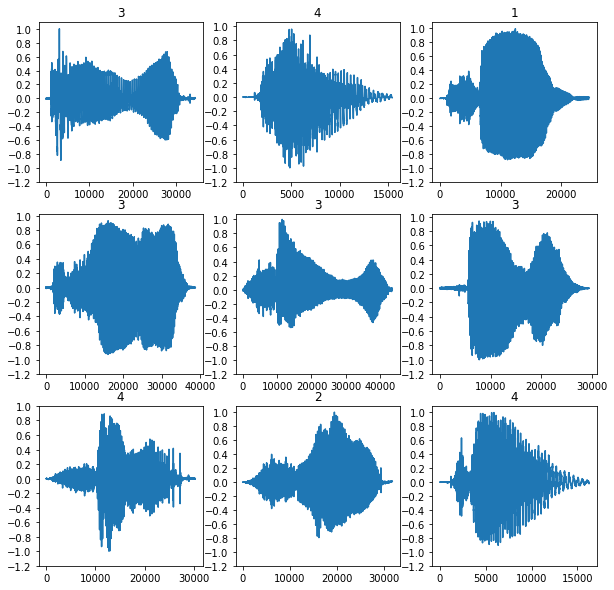

In [641]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
# for i, (audio, label) in enumerate(waveform_ds.take(n)):
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

## Spectrogram

You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

A Fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but loses all time information. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`. 

Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, you can refer to [this video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing. 

You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.


### Simplify Spectrogram

In [642]:
def simple_spec(spectrogram):

    ps = spectrogram

    # qt == quantile threshold
    
    qt = tf.math.reduce_max(ps)
    ps = tf.where(ps <= qt * 0.01, 0., ps)
    
    # remove 0s and simplify spectrogram with stats.quantiles
    
    zero_vector = tf.zeros(shape=(1), dtype=tf.float32)
    bool_mask = tf.not_equal(ps, zero_vector)
    ps_masked = tf.boolean_mask(ps, bool_mask)

    qt_s = tfp.stats.quantiles(ps_masked, num_quantiles=6, interpolation='nearest')
    
    qt0 = qt_s[0]
    qt1 = qt_s[1]
    qt2 = qt_s[2]
    qt3 = qt_s[3]
    qt4 = qt_s[4]
    qt5 = qt_s[5]
    qt6 = qt_s[6]
    
    print(qt_s)
  
    ps = tf.where(ps <= qt0, 0., ps)
    ps = tf.where((qt0 <= ps) & (ps <= qt1), 0., ps)
    ps = tf.where((qt1 <= ps) & (ps <= qt2), 0., ps)
    ps = tf.where((qt2 <= ps) & (ps <= qt3), 0., ps)
    ps = tf.where((qt3 <= ps) & (ps <= qt4), 0., ps)
    ps = tf.where((qt4 <= ps) & (ps <= qt5), 0.4, ps)
    ps = tf.where((qt5 <= ps) & (ps <= qt6), 0.8, ps)
    ps = tf.where(ps >= qt6, 1., ps)

    simple_spec = ps
    
    return simple_spec

### Trimming Spectrogram

In [643]:
def get_mask (bool_mask):
    bool_mask_len = tf.cast(tf.shape(bool_mask)[0], tf.int64)
    bool_mask_index = tf.where(bool_mask)
    bool_mask_max = tf.reduce_max(bool_mask_index)
    bool_mask_min = tf.reduce_min(bool_mask_index)

    mask = tf.fill([bool_mask_max - bool_mask_min + 1], True)
    mask_pad_head = tf.fill([bool_mask_min], False)
    mask_pad_tail = tf.fill([bool_mask_len - bool_mask_max - 1], False)
    mask = tf.concat([mask_pad_head, mask, mask_pad_tail], axis=0)

    return  mask

def trim_spec(spectrogram):
    
    y_collapsed2x = tf.math.reduce_max(spectrogram, axis=0)
    x_collapsed2y = tf.math.reduce_max(spectrogram, axis=1)
    zero_vector = tf.zeros(shape=(1), dtype=tf.float32)

    x_bool_mask = tf.not_equal(y_collapsed2x, zero_vector)
    y_bool_mask = tf.not_equal(x_collapsed2y, zero_vector)

    mask_x = get_mask(x_bool_mask)
    mask_y = get_mask(y_bool_mask)

#   如果直接用 bool_mask 会导致一声时 y 轴 裁去太多
#     mask_x = x_bool_mask
#     mask_y = y_bool_mask

    trim_spec = tf.boolean_mask(spectrogram, mask_x, axis=1)
    trim_spec = tf.boolean_mask(trim_spec, mask_y, axis=0)

    print('trim_spec: ', trim_spec.shape)
    trim_spec_shape = tf.shape(trim_spec)
    
    pad_freq_2 = tf.zeros([trim_spec_shape[0], 128 - trim_spec_shape[1]])
    trim_spec = tf.concat([trim_spec, pad_freq_2], 1)
    print('trim_spec pad_y: ', trim_spec.shape)
    
    # if x > 64 strided_slice, if x <64 pad
    # 原来预想 64*64, 出现 dmin 报错，现改为 128*128
    
    trim_spec = tf.strided_slice(trim_spec, [0], [96])
    pad_t_0 = tf.zeros([96 - tf.shape(trim_spec)[0], 128])
    trim_spec = tf.concat([trim_spec, pad_t_0], 0)
    print('trim_spec pad_x: ', trim_spec.shape)

#     trim_spec = tf.boolean_mask(spectrogram, x_bool_mask, 1)
#     trim_spec = tf.boolean_mask(trim_spec, y_bool_mask, 0)
    
    return trim_spec

### Main Get Spectrogram

In [644]:
def get_spectrogram(waveform):

    print("waveform shape:", tf.shape(waveform))

    zero_padding = tf.zeros(audio_length - tf.shape(waveform), dtype=tf.float32)

    waveform = tf.cast(waveform, tf.float32)
    
    equal_length = tf.concat([waveform, zero_padding], 0)
    print("equal_length = ", equal_length.shape)
    stfts = tf.signal.stft(
        equal_length, frame_length=frame_length, frame_step=frame_step)  

#     stfts = tf.signal.stft(
#         waveform, frame_length=frame_length, frame_step=frame_step)  

    spectrograms = tf.abs(stfts)

    print(spectrograms.shape, spectrograms.dtype)
    
    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = int(stfts.shape[-1])

    lower_edge_hertz  = 120.0
    upper_edge_hertz  = 600.0
    num_mel_bins = 128
    sample_rate = 48000

    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
    upper_edge_hertz)

    mel_spectrograms = tf.tensordot(
    spectrograms, linear_to_mel_weight_matrix, 1)

    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))

    spectrogram = mel_spectrograms
    spectrogram = simple_spec(spectrogram)
    spectrogram = trim_spec(spectrogram)
    
    #   resized_spectrogram = tf.expand_dims(spectrogram, axis=-1)
    spectrogram = tf.expand_dims(spectrogram, axis=0)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    spectrogram = tf.image.resize(spectrogram, [48, 48], preserve_aspect_ratio=False)
    spectrogram = tf.squeeze(spectrogram)
    
    return spectrogram

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

waveform shape: tf.Tensor([34483], shape=(1,), dtype=int32)
equal_length =  (72000,)
(97, 8193) <dtype: 'float32'>
tf.Tensor(
[  4.079602    7.6788983  12.651506   20.579512   38.33883    95.6443
 407.6079   ], shape=(7,), dtype=float32)
trim_spec:  (45, 128)
trim_spec pad_y:  (45, 128)
trim_spec pad_x:  (96, 128)
Label: 3
Waveform shape: (34483,)
plot
Audio playback


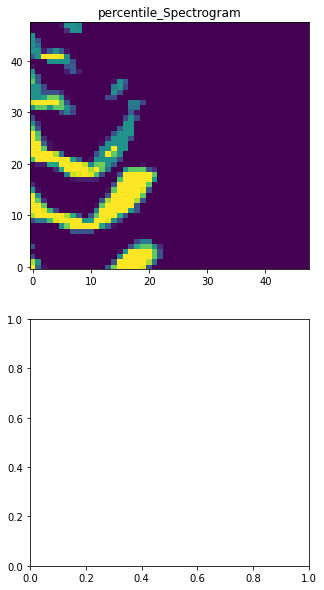

In [645]:
# for waveform, label, file_path in waveform_ds.take(1):
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)

    print("plot")

    def plot_spectrogram(spectrogram, ax):
        log_spec = spectrogram.T
        length = log_spec.shape[1]
        height = log_spec.shape[0]
    #     X = np.arange(spectro_x * (height + 1), step = height + 1)
        X = range(length)
        Y = range(height)
        # print('X = ', X)
        # print('Y = ', Y)
        ax.pcolormesh(X, Y, log_spec,shading='auto')

    fig, axes = plt.subplots(2, figsize=(5, 10))
    timescale = np.arange(waveform.shape[0])

#     plot_spectrogram(spectrogram.numpy(), axes[0])
    plot_spectrogram(spectrogram.numpy(), axes[0])

    axes[0].set_title('percentile_Spectrogram')

    # plot_norm_spectrogram(resized_spectrogram.numpy(), axes[1])
    # axes[1].set_title('resized_spectrogram')
    # plt.show()
#     print("end of plot")


    print('Audio playback')
    display.display(display.Audio(waveform, rate=48000))
    print("\n")

### Test one

test one

In [646]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).

  # 原教材中做了 log，此处把log 略去不做了。
  # log_spec = np.log(spectrogram.T)

    log_spec = spectrogram.T

    length = log_spec.shape[1]
    height = log_spec.shape[0]
#   X = np.arange(spectro_x * (height + 1), step = height + 1)
    
    X = range(length)
    Y = range(height)
    

    ax.pcolormesh(X, Y, log_spec, shading='auto')

# fig, axes = plt.subplots(2, figsize=(5, 10))
# timescale = np.arange(waveform.shape[0])

# axes[0].plot(timescale, waveform.numpy())
# axes[0].set_title('Waveform')
# axes[0].set_xlim([0, 48000*2])

# plot_spectrogram(spectrogram.numpy(), axes[1])
# axes[1].set_title('Spectrogram')

# plt.show()
# print("\n")
# display.display(display.Audio(waveform, rate=48000))

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [647]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)

    label_id = tf.argmax(label == tones)
    
    return spectrogram, label_id

In [648]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

waveform shape: Tensor("Shape:0", shape=(1,), dtype=int32)
equal_length =  (None,)
(None, 8193) <dtype: 'float32'>
Tensor("quantiles/percentile/SelectV2:0", shape=(7,), dtype=float32)
trim_spec:  (None, None)
trim_spec pad_y:  (None, None)
trim_spec pad_x:  (None, 128)


Examine the spectrogram "images" for different samples of the dataset.

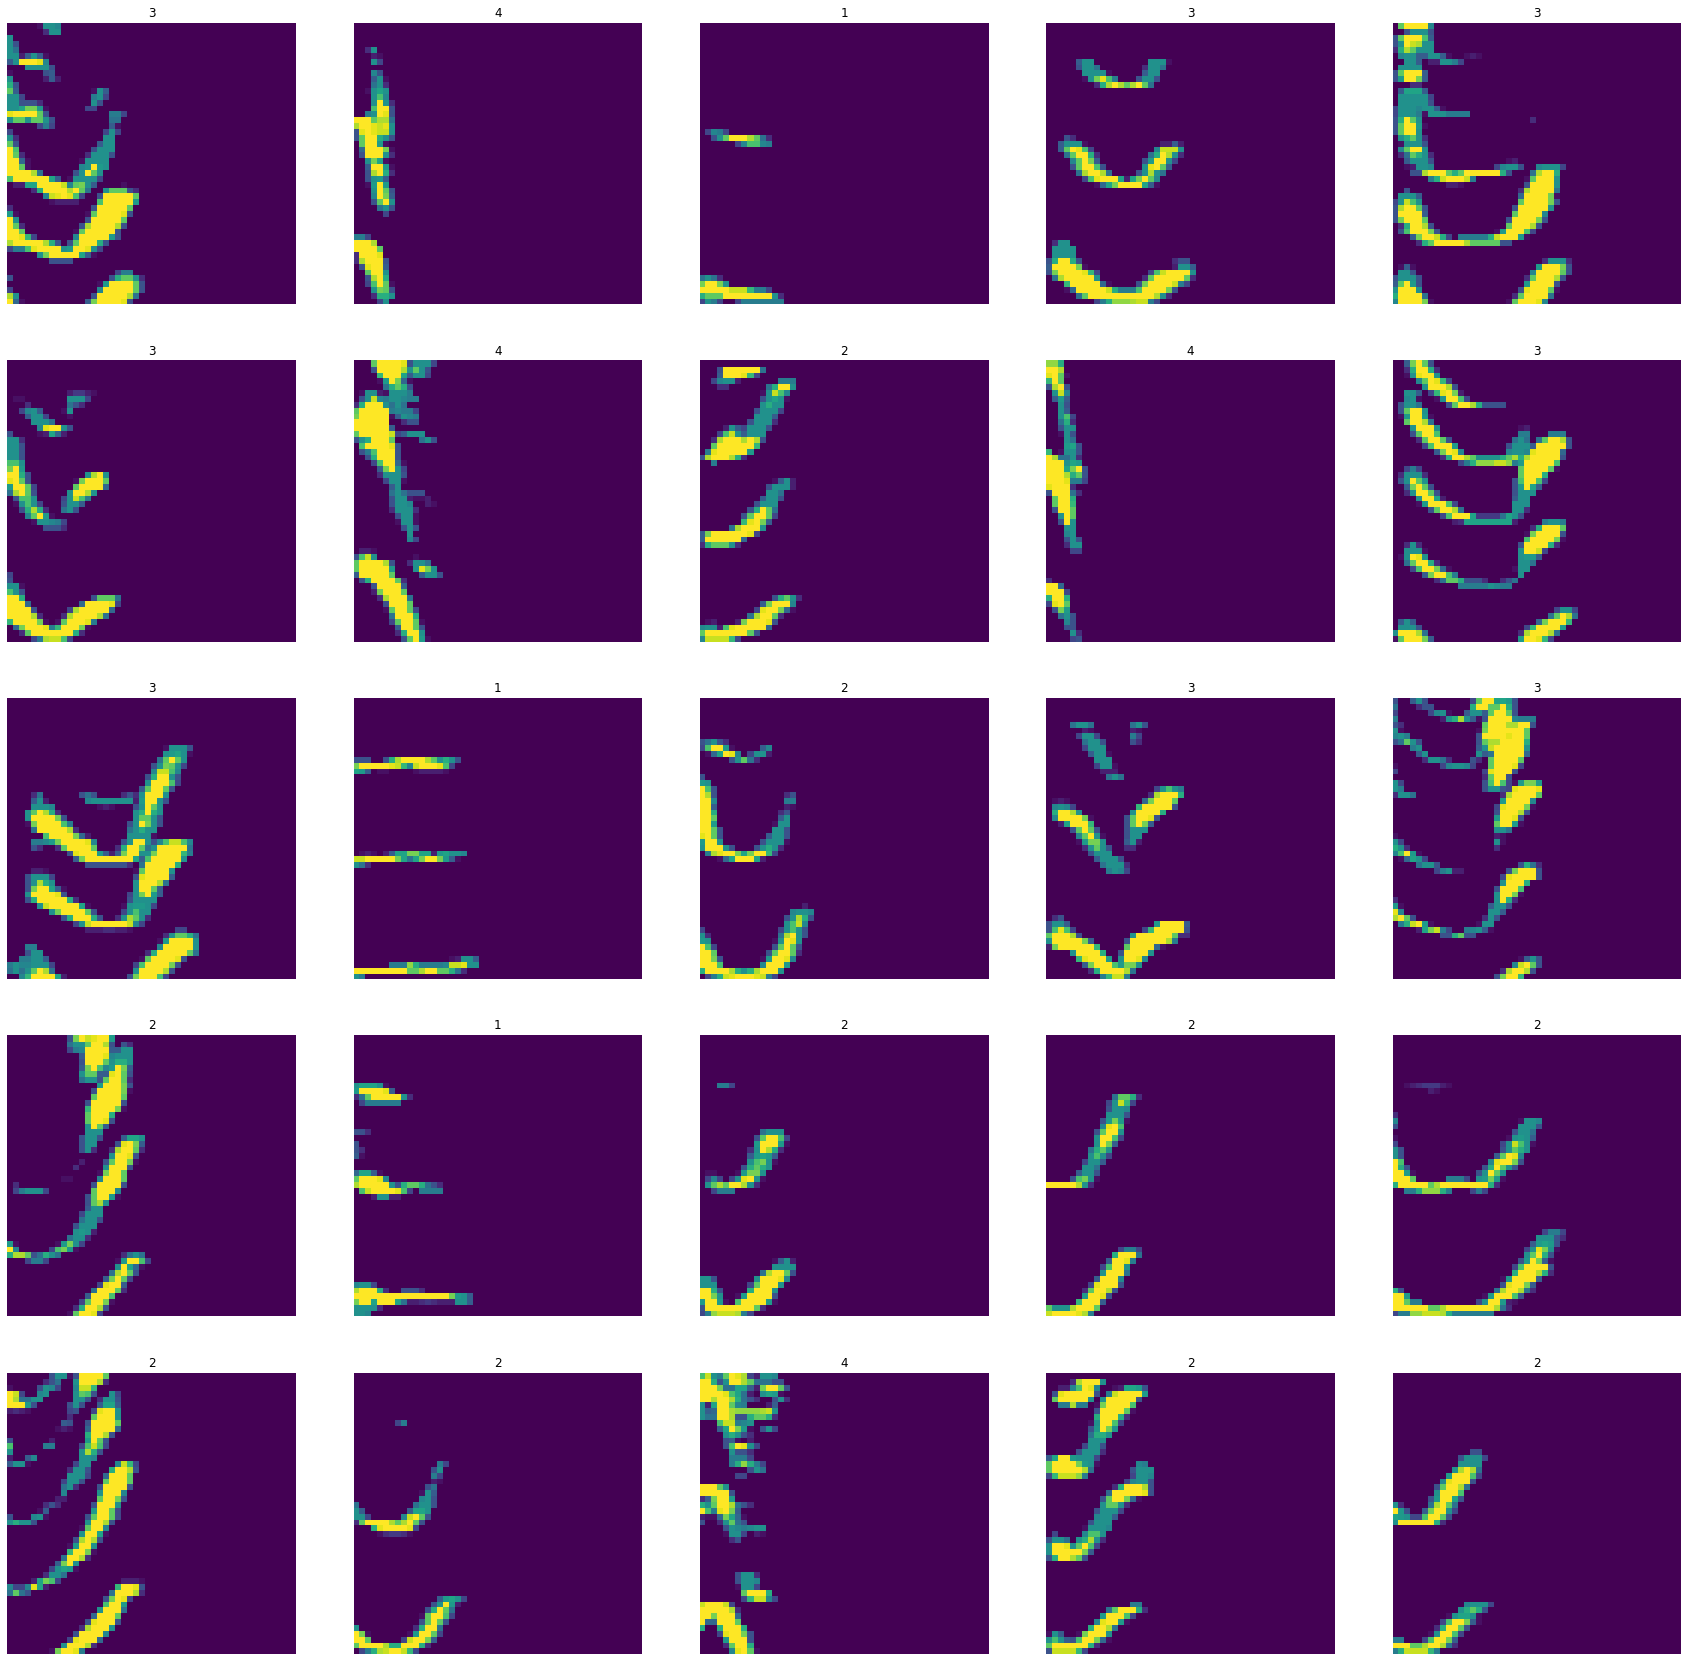

In [649]:
rows = 5
cols = 5
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(30, 30))


for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):

    r = i // cols
    c = i % cols
    ax = axes[r][c]

    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(tones[label_id.numpy()])
    ax.axis('off')
  
plt.show()

### test all

## Build and train the model

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [650]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    return output_ds

In [651]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Tone: Tensor("strided_slice:0", shape=(), dtype=string)
waveform shape: Tensor("Shape:0", shape=(1,), dtype=int32)
equal_length =  (None,)
(None, 8193) <dtype: 'float32'>
Tensor("quantiles/percentile/SelectV2:0", shape=(7,), dtype=float32)
trim_spec:  (None, None)
trim_spec pad_y:  (None, None)
trim_spec pad_x:  (None, 128)
Tone: Tensor("strided_slice:0", shape=(), dtype=string)
waveform shape: Tensor("Shape:0", shape=(1,), dtype=int32)
equal_length =  (None,)
(None, 8193) <dtype: 'float32'>
Tensor("quantiles/percentile/SelectV2:0", shape=(7,), dtype=float32)
trim_spec:  (None, None)
trim_spec pad_y:  (None, None)
trim_spec pad_x:  (None, 128)


### Change Test folder Shortcut

Batch the training and validation sets for model training.

In [652]:
batch_size = 80
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [653]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

### Tweak the model

In [682]:
for spectrogram, _  in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(tones)

norm_layer = preprocessing.Normalization()
print("norm_layer: ", norm_layer)
# norm_layer.adapt(spectrogram_ds.map(lambda x, y, z: x))
# norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))
print("norm_layer adapted: ", norm_layer)


model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(64, 64), 
    # norm_layer,
#     layers.Conv2D(8, 3, activation='relu'),
#     layers.Conv2D(32, 3, activation='relu'),
#     layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
#     layers.Dense(512*4, activation='relu'),
#     layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4),
])

model.summary()

Input shape: (48, 48, 1)
norm_layer:  <tensorflow.python.keras.layers.preprocessing.normalization.Normalization object at 0x000001F52699FAC0>
norm_layer adapted:  <tensorflow.python.keras.layers.preprocessing.normalization.Normalization object at 0x000001F52699FAC0>
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_8 (Resizing)        (None, 64, 64, 1)         0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 1)         0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32, 32, 1)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)            

In [683]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [684]:
# model_path = '/content/drive/MyDrive/PHI/'
model_path = 'Y:/PycharmProjects/'
training_date = '210413_4'
model_file = model_path + 'model_' + training_date + '.h5'

In [685]:
EPOCHS = 100

cp = tf.keras.callbacks.ModelCheckpoint(model_file, monitor='val_loss',
                      save_best_only=True, save_weights_only=False,
                      mode='auto', save_zfreq='epoch', verbose=1)

history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    # callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2), cp],
    callbacks=[cp],
)

Epoch 1/100
52/52 [==============================] - 1s 9ms/step - loss: 1.0132 - accuracy: 0.6128 - val_loss: 0.3208 - val_accuracy: 0.9360

Epoch 00001: val_loss improved from inf to 0.32080, saving model to Y:/PycharmProjects\model_210413_4.h5
Epoch 2/100
52/52 [==============================] - 0s 7ms/step - loss: 0.3142 - accuracy: 0.9248 - val_loss: 0.1913 - val_accuracy: 0.9575

Epoch 00002: val_loss improved from 0.32080 to 0.19128, saving model to Y:/PycharmProjects\model_210413_4.h5
Epoch 3/100
52/52 [==============================] - 0s 7ms/step - loss: 0.2106 - accuracy: 0.9441 - val_loss: 0.1403 - val_accuracy: 0.9677

Epoch 00003: val_loss improved from 0.19128 to 0.14030, saving model to Y:/PycharmProjects\model_210413_4.h5
Epoch 4/100
52/52 [==============================] - 0s 7ms/step - loss: 0.1577 - accuracy: 0.9576 - val_loss: 0.1201 - val_accuracy: 0.9717

Epoch 00004: val_loss improved from 0.14030 to 0.12009, saving model to Y:/PycharmProjects\model_210413_4.h5


Let's check the training and validation loss curves to see how your model has improved during training.

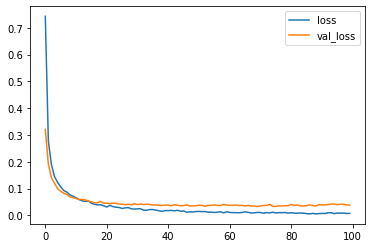

In [687]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate test set performance

Let's run the model on the test set and check performance.

In [688]:
test_audio = []
test_labels = []

# frame_length = 1024*4
# frame_step = 160

for audio, label in test_ds:

    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [689]:
model = tf.keras.models.load_model(model_file)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 92%


### Display a confusion matrix

A confusion matrix is helpful to see how well the model did on each of the commands in the test set.

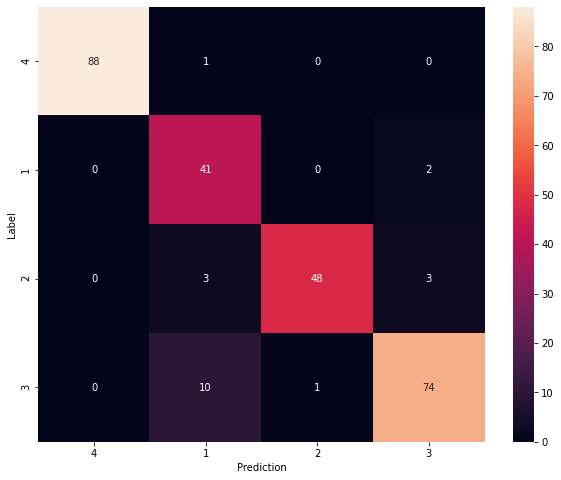

In [623]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=tones, yticklabels=tones, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no." How well does your model perform?

In [102]:
# sample_file = data_dir/'3/ba3.wav'

# sample_file_name = '/2/' + '00 - Bing_wav - 2nd tone 1 [2020-09-14 223633]-8' + '.wav'
# sample_file = data_dir_t + sample_file_name

sample_file = 'Y:/PycharmProjects/sound/mixed_clean/4/quickmandarin_gong4.wav'

# '1/00 - Bing_wav - 1st tone 1 [2020-09-14 222206]-6.wav'

sample_ds = preprocess_dataset([sample_file])

print('sample_ds')
print(sample_ds)
print('sample_ds')

for spectrogram, label in sample_ds.take(1):
#     prediction = model(spectrogram)
#     plt.bar(tones, tf.nn.softmax(prediction[0]))
#     plt.title(f'Predictions for "{tones[label[0]]}"')
#     plt.show()
    print('1')

    spectrogram = tf.squeeze(spectrogram)
    print('2')

    def plot_spectrogram(spectrogram, ax):
        log_spec = spectrogram.T
        length = log_spec.shape[1]
        height = log_spec.shape[0]
        X = range(length)
        Y = range(height)
        ax.pcolormesh(X, Y, log_spec,shading='auto')

    fig, axes = plt.subplots(2, figsize=(5, 10))
    timescale = np.arange(waveform.shape[0])
    print('3')

    plot_spectrogram(spectrogram.numpy(), axes[0])
    print('4')

    axes[0].set_title('Spectrogram')

Tone: Tensor("strided_slice:0", shape=(), dtype=string)
waveform shape: Tensor("Shape:0", shape=(1,), dtype=int32)
equal_length =  (None,)
(None, 8193) <dtype: 'float32'>
Tensor("quantiles/percentile/SelectV2:0", shape=(20,), dtype=float32)
trim_spec:  (None, None)
trim_spec pad_y:  (None, None)
trim_spec pad_x:  (None, 128)
sample_ds
<ParallelMapDataset shapes: ((48, 48, 1), ()), types: (tf.float32, tf.int64)>
sample_ds


InvalidArgumentError: slice index -1 of dimension 0 out of bounds.
	 [[{{node strided_slice}}]]

You can see that your model very clearly recognized the audio command as "no."

## Next steps

This tutorial showed how you could do simple audio classification using a convolutional neural network with TensorFlow and Python.

* To learn how to use transfer learning for audio classification, check out the [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial.

* To build your own interactive web app for audio classification, consider taking the [TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0).

* TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
